In [48]:
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.patches import Patch

In [49]:
time = 365
inc = 28
inf = 7

In [50]:
def create_hh():
    hh_size = np.random.choice([3, 4, 5, 6], size = 340, replace = True)
    hh_size = hh_size[np.cumsum(hh_size) < 1000]
    
    leftover = 1000 - hh_size.sum()
    if leftover < 3:
        # Randomly sample leftover amount indices from hh_size, and add one
        hh = np.arange(len(hh_size))
        idx = np.random.choice(hh[hh_size < 6], size = leftover, replace = False)
        hh_size[idx] += 1
    else:
        hh_size = np.append(hh_size, leftover)
    return hh_size

In [51]:
def SEIR(beta_H, beta_C, inc, inf):
    hh_size = create_hh()
    
    data = pd.DataFrame({'ID': range(1000),
                         'SIZE': np.repeat(hh_size, repeats = hh_size),
                         'HH': np.repeat(range(len(hh_size)), repeats = hh_size),
                         'S': np.append(0, np.ones(999)),
                         'E': np.append(1, np.zeros(999)),
                         'E_count': np.append(1, np.zeros(999)),
                         'I': np.zeros(1000),
                         'I_count': np.zeros(1000),
                         'R': np.zeros(1000),
                         'INC': np.append(np.round(stats.norm.rvs(inc, 2)), np.zeros(999)),
                         'INF': np.zeros(1000)
                        })
    
    results = data.loc[:, 'ID':'HH']
    results['TYPE'] = np.nan
    results.loc[0, 'TYPE'] = '0'
    results['TIME'] = np.nan
    results.loc[0, 'TIME'] = 0
    
    for t in range(time):
        if t % 10 == 0: print(t, end = ' ')
        recovered = (data['INF'] > 0) & (data['I_count'] == data['INF'])
        if sum(recovered) > 0:
            data.loc[recovered, 'R'] = 1
            data.loc[recovered, 'I'] = 0

            # Why is this count set to 0 once they recover?
            data.loc[recovered, 'I_count'] = 0

        new_inf = (data['INC'] > 0) & (data['E_count'] == data['INC'])
        num_new_inf = sum(new_inf)

        if num_new_inf > 0:
            # Why do new infections have SD = 1?
            random_inf = np.round(stats.norm.rvs(inf, 1, size = num_new_inf))
            data.loc[new_inf, 'I'] = 1
            data.loc[new_inf, 'INF'] = random_inf
            data.loc[new_inf, 'E'] = 0

            # Why is this set to 0?
            data.loc[new_inf, 'E_count'] = 0

        I_H = data.groupby('HH').sum()['I']
        summary = pd.DataFrame({'I_H': I_H, 
                                'I_C': data.sum()['I'] - I_H
                               })
        dd = data[['HH', 'S']].copy()

        dd['I_H'] = dd.apply(lambda x: summary.loc[x['HH'], 'I_H'], axis = 1)
        dd['I_C'] = dd.apply(lambda x: summary.loc[x['HH'], 'I_C'], axis = 1)

        risk_H = dd['S'] * beta_H * dd['I_H'] / 1000
        risk_C = dd['S'] * beta_C * dd['I_C'] / 1000

        new_inf_H = stats.binom.rvs(1, risk_H, size = data.shape[0])
        new_inf_C = stats.binom.rvs(1, risk_C, size = data.shape[0])
        new_exposed = (new_inf_H == 1) | (new_inf_C == 1)

        num_new_exposed = sum(new_exposed)
        if num_new_exposed > 0:
            data.loc[new_exposed, 'E'] = 1
            # Why is this calculated only upon exposure?
            random_inc = np.round(stats.norm.rvs(inc, 2, size = num_new_exposed))
            data.loc[new_exposed, 'E'] = 1
            data.loc[new_exposed, 'INC'] = random_inc

            results['TYPE'].where(~((new_inf_H == 1) & (new_inf_C == 1)) | ~pd.isna(results['TYPE']), 'B', inplace = True)
            results['TYPE'].where(~(new_inf_H == 1) | ~pd.isna(results['TYPE']), 'H', inplace = True)
            results['TYPE'].where(~(new_inf_C == 1) | ~pd.isna(results['TYPE']), 'C', inplace = True)
            results['TIME'].where(~(new_exposed == 1) | ~pd.isna(results['TIME']), t, inplace = True)
        
        data.loc[data['E'] == 1, 'E_count'] += 1
        data.loc[data['I'] == 1, 'I_count'] += 1
        data.loc[data['E'] == 1, 'S'] = 0

    return results
        

In [52]:
def metrics(results):
    state = results[~pd.isna(results['TIME'])]
    incidence = state.shape[0]/1000
    
    prop_hh = np.nan
    if incidence != 0:
        prop_hh = state[state['TYPE'] == 'H'].shape[0] / state.shape[0]
    
    return incidence, prop_hh

In [53]:
def mse(results, target):
    return ((np.array(metrics(results)) - target)**2).sum()

def bce(results, target):
    incidence, prop_hh = metrics(results)
    
    incidence_loss = target[0] * np.log(incidence + eps) + (1 - target[0]) * np.log(1 - incidence + eps)
    prop_hh_loss = target[1] * np.log(prop_hh + eps) + (1 - target[1]) * np.log(1 - prop_hh + eps)
    return incidence_loss + prop_hh_loss

# 10 February

In [ ]:
idcs = np.load('results/archive/idcs_3.npy')
prps = np.load('results/archive/prps_3.npy')

beta_C_vals = np.load('results/archive/beta_C_vals_3.npy')
beta_H_vals = np.load('results/archive/beta_H_vals_3.npy')
cc, hh = np.meshgrid(beta_C_vals, beta_H_vals)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (9.5, 3.5))

plot_hh = axs[0].scatter(idcs.flatten(), prps.flatten(), c = hh.flatten(), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm HH}$')
plt.colorbar(plot_hh, ax = axs[0])

axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)
axs[0].set_title(r'$\beta_H$', loc = 'left')

plot_cc = axs[1].scatter(idcs.flatten(), prps.flatten(), c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm HH}$')
plt.colorbar(plot_cc, ax = axs[1])

axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)
axs[1].set_title(r'$\beta_C$', loc = 'left')

plt.savefig('plots/prp_vs_inc_1.png', transparent = True, dpi = 300)

In [ ]:
idx = (idcs >= 0.09) & (idcs <= 0.11) & (prps >= 0.2) & (prps <= 0.3)

In [ ]:
hh[idx], cc[idx]

In [ ]:
hh

In [ ]:
cc

In [ ]:
results = SEIR(23.8, 0.22, num_weeks_inf, num_weeks_inc)

In [ ]:
metrics(results)

## More Results

In [ ]:
idcs = np.load('results/1/idcs.npy')
prps = np.load('results/1/prps.npy')

cc = np.load('results/1/cc.npy')
hh = np.load('results/1/hh.npy')

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (9.5, 3.5))

plot_hh = axs[0].scatter(idcs.flatten(), prps.flatten(), 
                         c = np.repeat(hh.flatten(), 5), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm HH}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(idcs.flatten(), prps.flatten(), 
                         c = np.repeat(cc.flatten(), 5), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm HH}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plt.savefig('prp_vs_inc_2.png', transparent = True, dpi = 300)

# 14 February

Results for a $\beta_H$ grid of $[20, 20.8, 21.6, \ldots, 39.2, 40]$ and $\beta_C$ grid of $[0, 0.04, 0.08, \ldots, 0.96, 1]$.

In [ ]:
idcs = np.load('results/2/idcs.npy')
prps = np.load('results/2/prps.npy')

cc = np.load('results/2/cc.npy')
hh = np.load('results/2/hh.npy')

In [ ]:
mean_idcs = idcs.mean(axis = 2)
mean_prps = prps.mean(axis = 2)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3.5))

plot_hh = axs[0].scatter(mean_idcs.flatten(), mean_prps.flatten(), 
                         c = hh.flatten(), alpha = 0.5)

axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm HH}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(mean_idcs.flatten(), mean_prps.flatten(), 
                         c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm HH}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/prp_vs_inc_2.png', transparent = True, dpi = 300)

Results for a $\beta_H$ grid of $[10, 12, 14, \ldots, 48, 50]$ and $\beta_C$ grid of $[0, 0.1, 0.2, \ldots, 1.9, 2]$.

In [ ]:
idcs = np.load('results/3/idcs_3.npy')
prps = np.load('results/3/prps_3.npy')

cc = np.load('results/3/cc_3.npy')
hh = np.load('results/3/hh_3.npy')

In [ ]:
mean_idcs = idcs.mean(axis = 2)
mean_prps = prps.mean(axis = 2)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3.5))

plot_hh = axs[0].scatter(mean_idcs.flatten(), mean_prps.flatten(), 
                         c = hh.flatten(), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm HH}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(mean_idcs.flatten(), mean_prps.flatten(), 
                         c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm HH}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/prp_vs_inc_3.png', transparent = True, dpi = 300)

# 15 February

In [ ]:
idcs_1 = np.load('results/4/idcs_1.npy')
prps_1 = np.load('results/4/prps_1.npy')

idcs_2 = np.load('results/4/idcs_2.npy')
prps_2 = np.load('results/4/prps_2.npy')

idcs_3 = np.load('results/4/idcs_3.npy')
prps_3 = np.load('results/4/prps_3.npy')

beta_H_vals = [20.6, 30, 29.6]
beta_C_vals = [0.30, 0.12, 0.20]

In [ ]:
fig, axs = plt.subplots(3, 2, figsize = (10, 16))
bins = np.linspace(0, 1, 51)

axs[0][0].hist(idcs_1, bins = bins)
axs[0][1].hist(prps_1, bins = bins)
axs[0][0].set_xlim(0, 1)
axs[0][1].set_xlim(0, 1)
axs[0][0].set_title(r'$\beta_H = 20.6$, $\beta_C = 0.30$', loc = 'left')
axs[0][0].set_xlabel('Incidence')
axs[0][1].set_xlabel('Proportion HH')

axs[1][0].hist(idcs_2, bins = bins)
axs[1][1].hist(prps_2, bins = bins)
axs[1][0].set_xlim(0, 1)
axs[1][1].set_xlim(0, 1)
axs[1][0].set_title(r'$\beta_H = 30$, $\beta_C = 0.12$', loc = 'left')
axs[1][0].set_xlabel('Incidence')
axs[1][1].set_xlabel('Proportion of Infections from Household')

axs[2][0].hist(idcs_3, bins = bins)
axs[2][1].hist(prps_3, bins = bins)
axs[2][0].set_xlim(0, 1)
axs[2][1].set_xlim(0, 1)
axs[2][0].set_title(r'$\beta_H = 29.6$, $\beta_C = 0.20$', loc = 'left')
axs[2][0].set_xlabel('Incidence')
axs[2][1].set_xlabel('Proportion of Infections from Household')
plt.savefig('plots/param_check.png', transparent = False, dpi = 300)

In [ ]:
idcs_1.mean(), prps_1.mean()

In [ ]:
idcs_2.mean(), prps_2.mean()

In [ ]:
idcs_3.mean(), prps_3.mean()

In [ ]:
idcs_3[prps_3 == 1]

In [ ]:
prps_1[idcs_1 == 0]

In [ ]:
prps_2[idcs_2 == 0]

In [ ]:
prps_3[idcs_3 == 0]

# 28 February

In [54]:
def metrics(results):
    state = results[~pd.isna(results['TIME'])]
    i = state.shape[0]/1000
    
    #p_hh = np.nan
    #if i != 0:
    #    p_hh = state[state['TYPE'] == 'H'].shape[0] / state.shape[0]
    #return i, p_hh
    
    sar = np.nan
    if i != 0:
        num_primary = np.sum(results.groupby('HH')['TIME'].sum() > 0) # households that were infected
        idx = results.groupby('HH')['TYPE'].apply(lambda x: ~np.all(x.isna()))
        num_contact = (results.groupby('HH')['SIZE'].sum()[idx]**(1/2)).sum() # total people in all those households
        sar = state[(state['TYPE'] == 'H') | (state['TYPE'] == 'B')].shape[0] / (num_contact - num_primary)
    
    return i, sar

In [55]:
chain = np.load('results/5/chain_2.npy')

Text(0, 0.5, '$\\beta_C$')

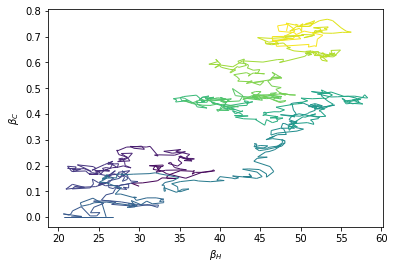

In [56]:
from matplotlib.collections import LineCollection

x = chain[:, 0]
y = chain[:, 1]
cs = np.linspace(0,1,len(x))

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots()
lc = LineCollection(segments, cmap='viridis')
lc.set_array(cs)
lc.set_linewidth(1)
line = ax.add_collection(lc)
ax.autoscale()
plt.xlabel(r'$\beta_H$')
plt.ylabel(r'$\beta_C$')
# Plot loss value over iterations
# Deliverables
# Update MCMC (by Wednesday)
# - save likelihood
# - each iteration averages over 100 iterations (NUM_ITER)
# Implement SAR (by Friday)
# Test R code on local device

In [57]:
best = np.load('results/5/best_2.npy')

In [58]:
beta_H, beta_C = best

In [59]:
idcs = np.load('results/6/idcs_5.npy')
sars = np.load('results/6/sars_5.npy')

cc = np.load('results/6/cc_5.npy')
hh = np.load('results/6/hh_5.npy')

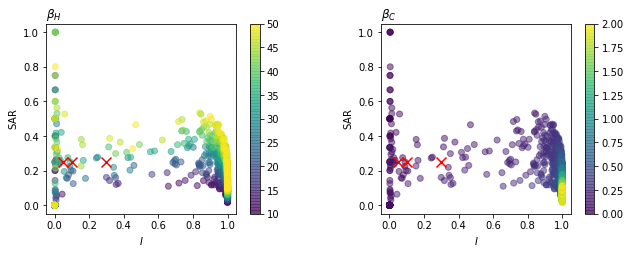

In [60]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3.5))

plot_hh = axs[0].scatter(idcs.flatten(), sars.flatten(), 
                         c = hh.flatten(), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$\rm SAR$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(idcs.flatten(), sars.flatten(), 
                         c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$\rm SAR$')
axs[1].set_aspect('equal')
fig.colorbar(plot_cc, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/prp_vs_sar.png', transparent = True, dpi = 300)

In [61]:
cc[(idcs > 0.05) & (idcs < 0.15)]

array([0.1 , 0.15, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.05])

In [62]:
hh[(idcs > 0.05) & (idcs < 0.15)]

array([19., 20., 21., 22., 23., 24., 27., 30., 35., 36., 48.])

In [63]:
cc[(idcs > 0.25) & (idcs < 0.35)]

array([0.15, 0.15, 0.2 , 0.15, 0.1 , 0.1 ])

In [64]:
hh[(idcs > 0.25) & (idcs < 0.35)]

array([15., 17., 25., 30., 38., 48.])

In [65]:
cc[(idcs > 0.01) & (idcs < 0.07)]

array([0.15, 0.2 , 0.1 , 0.05, 0.05, 0.1 , 0.1 , 0.05, 0.1 , 0.05, 0.1 ,
       0.05, 0.1 , 0.05, 0.05, 0.15])

In [66]:
hh[(idcs > 0.01) & (idcs < 0.07)]

array([11., 11., 23., 26., 29., 30., 31., 32., 32., 34., 37., 40., 40.,
       45., 48., 49.])

In [93]:
beta_Hs = np.linspace(5, 35, 61)
beta_Cs = np.linspace(0, 1, 21)

In [94]:
beta_Hs

array([ 5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ,
       10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5,
       16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. ,
       21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5,
       27. , 27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. ,
       32.5, 33. , 33.5, 34. , 34.5, 35. ])

In [ ]:
i = 1, j = 0

In [106]:
for i in range(3):
    for j in range(4):
        for k in range(5):
            print(20*i + 5*j + k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [22]:
%%time
SEIR(beta_H, beta_C, inc, inf)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 CPU times: user 48.4 s, sys: 5.26 ms, total: 48.4 s
Wall time: 49.2 s


,ID,SIZE,HH,TYPE,TIME
0,0,5,0,0,0.0
1,1,5,0,NaN,NaN
2,2,5,0,NaN,NaN
3,3,5,0,NaN,NaN
4,4,5,0,NaN,NaN
...,...,...,...,...,...
995,995,6,226,NaN,NaN
996,996,6,226,NaN,NaN
997,997,6,226,NaN,NaN
998,998,6,226,NaN,NaN


In [25]:
beta_H, beta_C

(26.210651842940592, 0.11921066815772194)

In [14]:
n = 25
sars = [None]*n
idcs = [None]*n
for i in range(n):
    print(i, end = ' ')
    results = SEIR(beta_H, beta_C, inc, inf)
    idc, sar = metrics(results)
    idcs[i] = idc
    sars[i] = sar
    print()

0 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 
1 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 
2 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 
3 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 
4 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 
5 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 
6 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 
7 0 10 20 30 40 50 6

In [18]:
np.mean(idcs)

0.09128

(array([14.,  3.,  1.,  1.,  2.,  0.,  1.,  1.,  0.,  2.]),
 array([0.001 , 0.0421, 0.0832, 0.1243, 0.1654, 0.2065, 0.2476, 0.2887,
        0.3298, 0.3709, 0.412 ]),
 <a list of 10 Patch objects>)

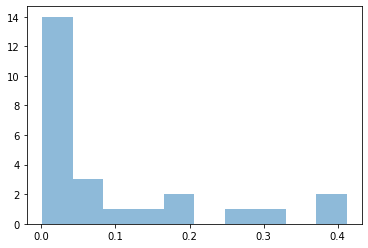

In [15]:
plt.hist(idcs, alpha = 0.5)

In [19]:
np.mean(sars)

0.24327622289771203

(array([ 3.,  1., 10.,  6.,  2.,  0.,  2.,  0.,  0.,  1.]),
 array([0.  , 0.08, 0.16, 0.24, 0.32, 0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 ]),
 <a list of 10 Patch objects>)

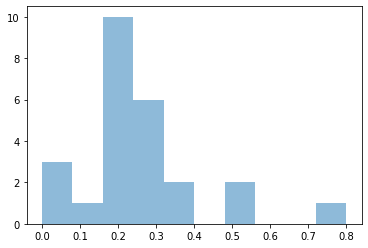

In [16]:
plt.hist(sars, alpha = 0.5)

In [26]:
chain

array([[30.        ,  0.12      ],
       [29.03715339,  0.13167389],
       [29.03715339,  0.13167389],
       ...,
       [47.1427555 ,  0.74216538],
       [48.43066333,  0.74830859],
       [48.24476865,  0.72258578]])

In [28]:
np.unique(chain).shape

(1763,)

In [31]:
np.prod(chain.shape)

2002

# 6 March 

In [40]:
best = np.load('results/8/best.npy')
liks = np.load('results/8/liks.npy')

In [39]:
best

array([35.76599714,  0.14174176])

In [44]:
liks[:, 0]

array([4.61099932, 4.61099932, 4.85694691, ..., 3.13741919, 3.06893261,
       2.95031712])

In [ ]:
# How many simulations per parameter set: Pick 5 parameter sets and check them on different simulation sizes (10, 50, 100, 250, 500, 750, 1000)
# Sophia will test on Winton
# Paralellize code
# MCMC fits to stochastic models: harder to find the global optimum. Initial guess makes a big difference.
# Grid search to get better initial guess.

In [46]:
chain

array([[30.        ,  0.12      ],
       [30.        ,  0.12      ],
       [29.78542435,  0.13101515],
       ...,
       [40.19634317,  0.13330645],
       [41.01770446,  0.12921748],
       [38.80154614,  0.12963488]])

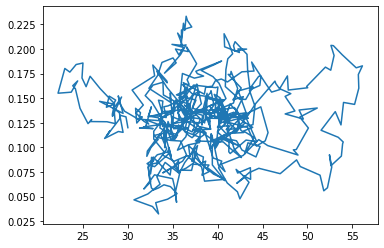

In [47]:
plt.plot(chain[:, 0], chain[:, 1])

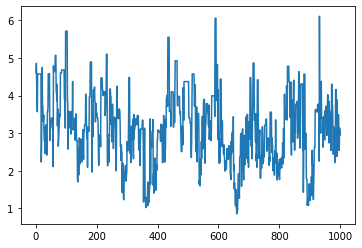

In [45]:
plt.plot(liks[:, 0])

In [42]:
chain = np.load('results/8/chain.npy')

In [43]:
chain

array([[30.        ,  0.12      ],
       [30.        ,  0.12      ],
       [29.78542435,  0.13101515],
       ...,
       [40.19634317,  0.13330645],
       [41.01770446,  0.12921748],
       [38.80154614,  0.12963488]])